[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

#Setup

In [ ]:
# Install miniconda environment
!wget -c https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local

import sys
sys.path.append('/usr/local/lib/python3.9/site-packages/')

--2021-09-01 12:01:16--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66709754 (64M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  63.62M   228MB/s    in 0.3s    

2021-09-01 12:01:16 (228 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [66709754/66709754]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - _openmp_mutex==4.5=1_gnu
    - brotlipy==0.7.0=py39h27cfd23_1003
    - ca-certificates==2021.7.5=h06a4308_1
    - certifi==2021.5.30=py39h06a4308_0
    - cffi==1.14.6=py39h400218f_0
    - chardet==4.0.0=py3

In [ ]:
!pip -q install optuna
!pip -q install rdp
!pip -q install vg
!conda install -q -y --prefix /usr/local -c pyomeca -c conda-forge pyomeca

     |████████████████████████████████| 302 kB 14.7 MB/s 
     |████████████████████████████████| 40 kB 4.2 MB/s 
     |████████████████████████████████| 28.5 MB 70 kB/s 
     |████████████████████████████████| 208 kB 85.2 MB/s 
     |████████████████████████████████| 80 kB 7.8 MB/s 
     |████████████████████████████████| 630 kB 60.5 MB/s 
     |████████████████████████████████| 1.5 MB 57.8 MB/s 
     |████████████████████████████████| 15.8 MB 21 kB/s 
     |████████████████████████████████| 67 kB 5.4 MB/s 
     |████████████████████████████████| 147 kB 77.0 MB/s 
     |████████████████████████████████| 75 kB 3.6 MB/s 
     |████████████████████████████████| 141 kB 93.1 MB/s 
     |████████████████████████████████| 111 kB 77.1 MB/s 
     |████████████████████████████████| 49 kB 5.0 MB/s 
     |████████████████████████████████| 53 kB 1.2 MB/s 
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - pyomeca


The fo

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

class LayerNormLSTMCell(nn.LSTMCell):

    def __init__(self, input_size, hidden_size, bias=True):
        super().__init__(input_size, hidden_size, bias)

        self.ln_ih = nn.LayerNorm(4 * hidden_size)
        self.ln_hh = nn.LayerNorm(4 * hidden_size)
        self.ln_ho = nn.LayerNorm(hidden_size)

    def forward(self, input, hidden=None):
        self.check_forward_input(input)
        if hidden is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)
            cx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)
        else:
            hx, cx = hidden
        self.check_forward_hidden(input, hx, '[0]')
        self.check_forward_hidden(input, cx, '[1]')

        gates = self.ln_ih(F.linear(input, self.weight_ih, self.bias_ih)) \
                 + self.ln_hh(F.linear(hx, self.weight_hh, self.bias_hh))
        i, f, o = gates[:, :(3 * self.hidden_size)].sigmoid().chunk(3, 1)
        g = gates[:, (3 * self.hidden_size):].tanh()

        cy = (f * cx) + (i * g)
        hy = o * self.ln_ho(cy).tanh()
        return hy, cy


class LayerNormLSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers=1, bias=True, 
                 bidirectional=False, batch_first=False):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.batch_first = batch_first

        num_directions = 2 if bidirectional else 1
        self.hidden0 = nn.ModuleList([
            LayerNormLSTMCell(input_size=(input_size if layer == 0 else hidden_size * num_directions),
                              hidden_size=hidden_size, bias=bias)
            for layer in range(num_layers)
        ])

        if self.bidirectional:
            self.hidden1 = nn.ModuleList([
                LayerNormLSTMCell(input_size=(input_size if layer == 0 else hidden_size * num_directions),
                                  hidden_size=hidden_size, bias=bias)
                for layer in range(num_layers)
            ])

    def forward(self, input, hidden=None):
        if self.batch_first: # (batch, seq, feature) instead of (seq, batch, feature)
            input = input.transpose(0, 1)
        seq_len, batch_size, hidden_size = input.size()  # supports TxNxH only
        num_directions = 2 if self.bidirectional else 1
        if hidden is None:
            hx = input.new_zeros(self.num_layers * num_directions, batch_size, self.hidden_size, requires_grad=False)
            cx = input.new_zeros(self.num_layers * num_directions, batch_size, self.hidden_size, requires_grad=False)
        else:
            hx, cx = hidden

        ht = [[None, ] * (self.num_layers * num_directions)] * seq_len
        ct = [[None, ] * (self.num_layers * num_directions)] * seq_len

        if self.bidirectional:
            xs = input
            for l, (layer0, layer1) in enumerate(zip(self.hidden0, self.hidden1)):
                l0, l1 = 2 * l, 2 * l + 1
                h0, c0, h1, c1 = hx[l0], cx[l0], hx[l1], cx[l1]
                for t, (x0, x1) in enumerate(zip(xs, reversed(xs))):
                    ht[t][l0], ct[t][l0] = layer0(x0, (h0, c0))
                    h0, c0 = ht[t][l0], ct[t][l0]
                    t = seq_len - 1 - t
                    ht[t][l1], ct[t][l1] = layer1(x1, (h1, c1))
                    h1, c1 = ht[t][l1], ct[t][l1]
                xs = [torch.cat((h[l0], h[l1]), dim=1) for h in ht]
            y  = torch.stack(xs)
            hy = torch.stack(ht[-1])
            cy = torch.stack(ct[-1])
        else:
            h, c = hx, cx
            for t, x in enumerate(input):
                for l, layer in enumerate(self.hidden0):
                    ht[t][l], ct[t][l] = layer(x, (h[l], c[l]))
                    x = ht[t][l]
                h, c = ht[t], ct[t]
            y  = torch.stack([h[-1] for h in ht])
            hy = torch.stack(ht[-1])
            cy = torch.stack(ct[-1])
        

        if self.batch_first:
            y = y.permute(0,1)

        return y, (hy, cy)

#A multimodal dataset of human gait at different walking speeds established on injury-free adult participants

Download the dataset

In [ ]:
!wget -q https://ndownloader.figshare.com/files/22295019 -O dataset.zip
!unzip -qq dataset.zip
!rm dataset.zip

## Define helper methods and classes

Define helper methods to load the c3d files and preprocess them for the RNN

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
from pyomeca import Markers, Analogs
from scipy.interpolate import interp1d
import xarray as xr
import numpy as np
import pandas as pd
import vg

PELVIS, RHIP, LHIP, RKNEE, LKNEE, RANKLE, LANKLE, VPELVIS, VRANKLE, VLANKLE = range(10)

def create_features(markers, in_freq=100, out_freq=-1):
    n_features = 10
    data = np.zeros((len(markers.axis), n_features, len(markers.time))) #(axis, joint, frame)
    # define pelvis, hip, knee and ankle joints from markers
    data[:, PELVIS] = markers.loc[:, ['R_IAS', 'L_IAS', 'R_IPS', 'L_IPS']].mean(axis=1).values
    data[:, RHIP] = 0.5 * (markers.loc[:, 'R_FTC'] + data[:, PELVIS])
    data[:, LHIP] = 0.5 * (markers.loc[:, 'L_FTC'] + data[:, PELVIS])
    data[:, RKNEE] = markers.loc[:, ['R_FLE', 'R_FME']].mean(axis=1).values
    data[:, LKNEE] = markers.loc[:, ['L_FLE', 'L_FME']].mean(axis=1).values
    data[:, RANKLE] = markers.loc[:, ['R_FAL', 'R_TAM']].mean(axis=1).values
    data[:, LANKLE] = markers.loc[:, ['L_FAL', 'L_TAM']].mean(axis=1).values
    data[:, VPELVIS:] = np.gradient(data[:, PELVIS], axis=-1)
    data[:, VRANKLE:VLANKLE+1] = np.gradient(data[:, RANKLE:LANKLE+1], axis=-1)
    #joint locations relative to pelvis
    data[:, RHIP:LANKLE+1] -= data[:, [PELVIS]]
    # pelvis relative to first frame
    data[:, PELVIS] -= data[:, PELVIS, [0]]
    # swap axes and reshape to (frame, channel)
    data = data.transpose([2,1,0]) # (frame, joint, axis)
    data = data.reshape(len(markers.time), -1) # (frame, joint * axis)    
    # up/downsampling if necessary
    if out_freq != -1 and in_freq != out_freq:
        scale_factor = in_freq // out_freq # should be a multiple
        old_x = np.linspace(0, 1, len(data))
        new_x = np.linspace(0, 1, len(data) // scale_factor)
        data = np.apply_along_axis(
            lambda y: interp1d(old_x, y, kind = 'cubic')(new_x),
            arr=data, axis=0
        )
    return data

def _norm_walking_dir(feature):
    x_axis = np.array([1,0,0])
    z_axis = np.array([0,0,1])

    orient = vg.angle((feature[:, LHIP] - feature[:, RHIP]), x_axis, look=z_axis)
    new_feature = feature.copy()
    for i in range(RHIP, LANKLE+1):
        new_feature[i] = vg.rotate(feature[i], z_axis, orient[i])
    return new_feature


def detect_step(v_force, treshold=10):
    step = v_force.meca.detect_onset(threshold=treshold, n_above=10, n_below=10)
    if step.size < 2:
        return [] # no step detected
    hs, to = step[0]
    return [hs, to]


def load_c3d_files(path, freq=100, cut_cycle=True):
    path = Path(path)
    landmarks = ['R_IAS', 'L_IAS', 'R_IPS', 'L_IPS', 'R_FTC', 'L_FTC', 'R_FLE', 'L_FLE', 
                 'R_FME', 'L_FME', 'R_FAL', 'L_FAL', 'R_TAM', 'L_TAM']
    channels = ['Fz1', 'Fz2']

    meta = []
    features = []
    targets = []

    for p in path.glob('*/*_C*.c3d'):
        name = p.stem
        id = int(name[4:7])
        cond = int(name[9])
        trial = int(name[-2:])

        grfs = -Analogs.from_c3d(p, suffix_delimiter=".", usecols=channels)
        GRF_FREQ = int(grfs.attrs['rate'])
        step1 = detect_step(grfs.sel(channel='Fz1'))
        step2 = detect_step(grfs.sel(channel='Fz2'))

        # skip trials with missed steps
        if not step1 or not step2: 
            continue
        steps = np.array([step1, step2]).transpose() # [[hs1,hs2],[to1,to2]]
        # downsample to target freq
        steps = steps / (GRF_FREQ // freq)
        steps = np.round(steps).astype(int)
        if np.any(np.diff(steps, axis=0) < 10): # way to less for a correct detection
            continue

        markers = Markers.from_c3d(p, prefix_delimiter=":")#, usecols=landmarks)
        if not np.isin(landmarks, markers.channel).all(): #missing marker
            continue
        MARKER_FREQ = int(markers.attrs['rate'])
        markers = markers / 1000
        feature = create_features2(markers.sel(axis=['y','x','z']),
                                  MARKER_FREQ, freq)
        
        v_pelvis = feature[:, VPELVIS*3+0]
        walking_dir = int(np.sign(np.mean(v_pelvis))) # +1 or -1

        gait_events = np.zeros((len(feature), 4)) # (N, [rhs,lhs,rto,lto])
        for i in range(4):
            t = max(0, min(len(feature)-1, steps[i//2, i%2])) # edge cases
            gait_events[t, i] = 1

        if cut_cycle:
            # only timespan with event detection
            step_lens = walking_dir * np.diff(steps[0]).item() #diff rhs - lhs
            start = max(0, int(np.min(steps[0]) - step_lens/4))
            end = min(len(feature), int(np.max(steps[1]) + step_lens/4))
            feature = feature[start:end]
            gait_events = gait_events[start:end]

        meta.append((id, cond, trial, walking_dir))
        features.append(feature)
        targets.append(gait_events)

    meta = pd.DataFrame(meta, columns=['id', 'cond', 'trial', 'walking_dir'])
    return features, targets, meta


def prepare_for_rnn(features, targets, meta, event='both'):
    rnn_features = []
    rnn_targets = []
    rnn_meta = pd.concat([meta, meta])

    for i in range(len(features)):
        f = features[i].reshape((-1, 10, 3))
        t = targets[i]  # [rhs,lhs,rto,lto]
        mhip = (f[:, [RHIP]] + f[:, [LHIP]]) / 2
        f = f - mhip # set mhip as zero instead of pelvis
        f = _norm_walking_dir(f)
        # debias (devide by femur len)
        femur_len_r = np.linalg.norm(f[:, RHIP] - f[:, RKNEE], axis=-1)
        femur_len_l = np.linalg.norm(f[:, LHIP] - f[:, LKNEE], axis=-1)
        femur_len = (femur_len_r + femur_len_l) / 2         # avg femur length in each frame
        f = f / femur_len[:, None, None]      # normalize each frame

        # create reduced feature set ignoring side
        for side in [0,1]: # right, left
            hs = t[:, side].nonzero()[0][0]
            to = t[:, 2+side].nonzero()[0][0]
            eps = np.int(0.33 * (to - hs)) # a third of a step
            start = max(0, hs - eps)
            end = min(len(f), to + eps)

            nf = np.zeros((end-start, 6, 3))
            nf[:, 0] = f[start:end, RHIP + side]
            nf[:, 1] = f[start:end, RKNEE + side]
            nf[:, 2] = f[start:end, RANKLE + side]
            nf[:, 3:6] = np.gradient(nf[:, :3], axis=0) # velocities

            nf = nf.reshape((len(nf), -1))
            if event == 'HS':
                nt = np.zeros((end-start, 1))
                nt[:,0] = t[start:end, side]
            elif event == 'TO':
                nt = np.zeros((end-start, 1))
                nt[:,0] = t[start:end, 2+side]
            else:
                nt = np.zeros((end-start, 2))
                nt[:, 0] = t[start:end, side]
                nt[:, 1] = t[start:end, 2+side]

            rnn_features.append(nf)
            rnn_targets.append(nt)

    return rnn_features, rnn_targets, rnn_meta


def load_dataset(path, freq=50):
    data = load_c3d_files(path, freq=freq, cut_cycle=False)
    return prepare_for_rnn(*data)

Define the PyTorch Dataset, DataLoader, the RNN Module and the training loop

In [ ]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import itertools as it
import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler

class GaitDataset(Dataset):
    def __init__(self, features, targets, scaler, window_size=32, stride=8, transform=None):
        #mean, std = scale
        X = []
        y = []
        for f, t in zip(features, targets):
            f_norm = scaler.transform(f) #(f - mean) / std
            X.append(self._sliding_view(f_norm, window=window_size, stride=stride))
            y.append(self._sliding_view(t, window=window_size, stride=stride))
        
        self.X = np.concatenate(X)
        self.y = np.concatenate(y)
        self.transform = transform

    def __getitem__(self, idx):
        sample = (self.X[idx], self.y[idx])
        if self.transform:
            sample = self.transform(sample)
        X, y = sample
        return torch.Tensor(X), torch.Tensor(y)
    
    def __len__(self):
        return len(self.X)

    def _sliding_view(self, array, start=0, window=3, stride=1):    
        sub_windows = (
            start + 
            np.expand_dims(np.arange(window), 0) +
            np.expand_dims(np.arange(len(array) - window + 1), 0).T
        )
        return array[sub_windows[::stride]]

class RandomNoise(object):
    def __init__(self, sigma=0.01):
        self.sigma = sigma

    def __call__(self, sample):
        x, y = sample
        return x + np.random.normal(0, self.sigma, x.shape), y

class RandomRotate(object):

  def __init__(self, min_angle=0, max_angle=2*np.pi, unit='rad', axis='z', order='xyz'):
      super(RandomRotate, self).__init__()
      self.axis = np.zeros(3)
      self.axis[order.index(axis)] = 1
      self.min_angle = min_angle if unit == 'rad' else np.deg2rad(min_angle)
      self.max_angle = max_angle if unit == 'rad' else np.deg2rad(max_angle)

  def __call__(self, sample):
      x, y = sample
      new_x = x.copy()
      angle = random.uniform(self.min_angle, self.max_angle)
      for i in range(len(x)):
          new_x[i] = vg.rotate(x[i].reshape((-1, 3)), self.axis, angle).reshape(-1)
      return new_x, y


class GaitEventModel(nn.Module):
    def __init__(self, d_in, d_out=1, hidden_dim=128, n_layers=3,  
                 dropout=0.25, bidirectional=False):
        super(GaitEventModel, self).__init__()
        self.gru = nn.GRU(
            d_in, hidden_dim, n_layers, 
            batch_first=True, dropout=dropout,
            bidirectional=bidirectional
        )
        if bidirectional:
            self.fc = nn.Linear(2*hidden_dim, d_out)
        else:
            self.fc = nn.Linear(hidden_dim, d_out)

    def forward(self, x):
        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x) # (batch_size, seq_length, hidden_size)

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out


def prepare_dataloaders(features, targets, meta, batch_size=64, window=32, stride=8,
                        train_transform=None):
    ## train, dev, test split
    # subject spit: 80% - 10% -10%
    subjects = meta['id'].unique()
    train_subj = subjects[:round(0.8*len(subjects))] # 34
    dev_subj = subjects[round(0.8*len(subjects)):-round(0.1*len(subjects))] # 4
    test_subj = subjects[-round(0.1*len(subjects)):] # 4

    # split features and targets by subjects
    def _create_split(subjects):
        mask = meta.id.isin(subjects).values
        X = list(it.compress(features, mask))
        y = list(it.compress(targets, mask))
        return X, y

    # calc mean and std of training data for standardization
    train_features, train_targets = _create_split(train_subj)
    scaler = MinMaxScaler(feature_range=(-1,1))
    for f in train_features:
        scaler.partial_fit(f)

    train_ds = GaitDataset(train_features, train_targets, scaler=scaler,
                           window_size=window, stride=stride, 
                           transform=train_transform)
    dev_ds = GaitDataset(*_create_split(dev_subj), scaler=scaler,
                           window_size=window, stride=stride)
    test_ds = GaitDataset(*_create_split(test_subj), scaler=scaler,
                           window_size=window, stride=stride)

    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    dev_dl = DataLoader(dev_ds, batch_size=2*batch_size)
    test_dl = DataLoader(test_ds, batch_size=2*batch_size)

    return train_dl, dev_dl, test_dl, scaler


def train_model(model, train_dl, dev_dl, lr=3e-4, epochs=50, wd=.02, pos_weight=100, verbose=False):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    pos_weights = torch.Tensor([pos_weight]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights) # sparse event -> weight with a factor of 100
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, 
                                              steps_per_epoch=len(train_dl), 
                                              epochs=epochs)

    for epoch in range(epochs):
        train_losses = []
        for X, y in train_dl:
            X, y = X.to(device), y.to(device)

            model.train()
            optimizer.zero_grad()

            yhat = model(X)#.squeeze()
            loss = criterion(yhat, y)
            loss.backward()
            optimizer.step()
            scheduler.step()

            train_losses.append(loss.item())

        dev_losses = []
        for X, y in dev_dl:
            X, y = X.to(device), y.to(device)

            model.eval()
            with torch.no_grad():
                yhat = model(X)
                loss = criterion(yhat, y)
                dev_losses.append(loss.item())

        train_loss = sum(train_losses) / len(train_losses)
        dev_loss = sum(dev_losses) / len(dev_losses)
        if verbose:
            print(f"Epoch {epoch}: train loss={train_loss:.3f}, dev loss={dev_loss:.3f}")
    
    return dev_loss

def evaluate(model, dl, pos_weight=100):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    pos_weights = torch.Tensor([pos_weight, pos_weight]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)

    losses = []
    for X, y in dl:
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            yhat = model(X)
            loss = criterion(yhat, y)
            losses.append(loss.item())

    avg_loss = sum(losses) / len(losses)
    return avg_loss

## Train the network

In [ ]:
# Load the data
path = Path("/content/A multimodal dataset of human gait at different walking speeds")
features, targets, meta = load_dataset(path)

In [ ]:
#randNoise = RandomNoise(0.02) # can be used to augment the training
train_dl, dev_dl, test_dl, scaler = prepare_dataloaders(features, targets, meta, batch_size=32,
                                                        window=16, stride=3, train_transform=None)
in_dim = features[0].shape[-1]
out_dim = features[0].shape[-1]

model = GaitEventModel(in_dim, out_dim, hidden_dim=32, n_layers=1, dropout=0.2, bidirectional=True)

In [ ]:
train_model(model, train_dl, dev_dl, epochs=50, lr=0.001, verbose=True, wd=.03)

Epoch 0: train loss=1.398, dev loss=1.389
Epoch 1: train loss=1.224, dev loss=1.168
Epoch 2: train loss=1.022, dev loss=1.048
Epoch 3: train loss=0.915, dev loss=0.974
Epoch 4: train loss=0.856, dev loss=0.940
Epoch 5: train loss=0.804, dev loss=0.929
Epoch 6: train loss=0.753, dev loss=0.843
Epoch 7: train loss=0.708, dev loss=0.825
Epoch 8: train loss=0.666, dev loss=0.739
Epoch 9: train loss=0.629, dev loss=0.722
Epoch 10: train loss=0.599, dev loss=0.730
Epoch 11: train loss=0.569, dev loss=0.674
Epoch 12: train loss=0.542, dev loss=0.658
Epoch 13: train loss=0.523, dev loss=0.643
Epoch 14: train loss=0.499, dev loss=0.618
Epoch 15: train loss=0.484, dev loss=0.642
Epoch 16: train loss=0.470, dev loss=0.630
Epoch 17: train loss=0.455, dev loss=0.662
Epoch 18: train loss=0.448, dev loss=0.596
Epoch 19: train loss=0.437, dev loss=0.650
Epoch 20: train loss=0.427, dev loss=0.609
Epoch 21: train loss=0.425, dev loss=0.642
Epoch 22: train loss=0.410, dev loss=0.636
Epoch 23: train loss=

0.6594254704231911

In [ ]:
# save weights
torch.save(model.state_dict(), 'gait_rnn_model_f50_w16_l4_h16.pth')
np.save('min_scale', np.stack([scaler.min_, scaler.scale_]))

## Use Optuna for hyperparameter search

In [ ]:
# Load the data (if not already done)
path = Path("/content/A multimodal dataset of human gait at different walking speeds")
features, targets, meta = load_dataset(path)

In [ ]:
import optuna
from sklearn.metrics import roc_auc_score

# define objective to optimize
def objective(trial):
    hidden_dim = trial.suggest_int('hidden_dims', 32, 128, log=True)
    bidirectional = True #trial.suggest_categorical('bidirectional', [True, False])
    n_layers = trial.suggest_int('n_layers', 2, 4)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    batch_size = trial.suggest_int('batch_size', 32, 256, log=True)
    window_size = 32 #trial.suggest_int('window_size', 16, 64, log=True)
    stride = trial.suggest_int('stride', 4, 16, log=True)
    pos_weight = trial.suggest_int('pos_weight', 50, 200)

    train_dl, dev_dl, test_dl = prepare_dataloaders(features, targets, meta,
                                                    batch_size=batch_size,
                                                    window=window_size, 
                                                    stride=stride)
    in_dim = features[0].shape[-1]
    out_dim = targets[0].shape[-1]

    model = GaitEventModel(in_dim, out_dim, hidden_dim, n_layers, 
                           dropout, bidirectional)
    dev_loss = train_model(model, train_dl, dev_dl, epochs=75, lr=0.001, 
                           pos_weight=pos_weight)

    return dev_loss 

study = optuna.create_study()
study.optimize(objective, n_trials=100)

study.best_params

##Eval results

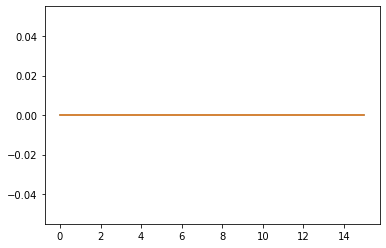

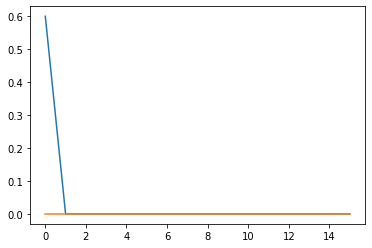

In [ ]:
x, y = next(iter(dev_dl))
i = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
x,y = x.to(device), y.to(device)
model.eval()
plt.plot(y.detach().cpu().numpy()[i]);
plt.show()
y_hat = torch.sigmoid(model(x))[i].detach()
y_hat[y_hat < 0.5] = 0
plt.plot(y_hat.cpu().numpy());
plt.show()

In [ ]:
# Test score
evaluate(model, test_dl)

0.577990374163441

##Use the demo data from DigiGait as test case

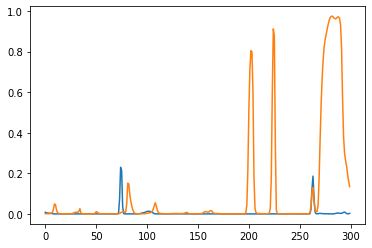

In [ ]:
import vg
from scipy.ndimage.filters import gaussian_filter1d
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d

data = np.load('demo_data.npz', allow_pickle=True)
pose = data['pose_3d'][:300]
lknee_angle = data['lknee_angle'][:300]
rknee_angle = data['lknee_angle'][:300]

def draw_skeleton(p, axis=0):
    plt.figure(figsize=(5,10))
    plt.scatter(p[:, axis], p[:, 2])
    for j in range(p.shape[0]):
        plt.text(p[j, axis], p[j, 2], str(j), color="red", fontsize=12)
    plt.show()

def _upscale(data, old_fs=50, new_fs=100):
    x = np.linspace(0, 1, len(data))
    new_x = np.linspace(0, 1, int(new_fs/old_fs * len(data)))
    return interp1d(x, data, 'cubic', axis=0)(new_x)

def _debias(pose):
    pose = pose.copy()
    pose[:, 1:] = pose[:, 1:] - pose[:, [0]]  # all joints relative to pelvis
    pose[:, 0] = pose[:, 0] - pose[[0], 0]    # pelvis relative to first frame

    femur_len_r = np.linalg.norm(pose[:, 1] - pose[:, 2], axis=-1)
    femur_len_l = np.linalg.norm(pose[:, 4] - pose[:, 5], axis=-1)
    femur_len = (femur_len_r + femur_len_l) / 2 # avg femur length in each frame
    pose = pose / femur_len[:, None, None]      # normalize each frame
    return pose

def _create_fvec(pose, hip, knee, ankle):
    f = np.zeros((len(pose), 6, 3))
    f[:, :3] = pose[:, [hip, knee, ankle]]    # position
    f[:, 3:] = np.gradient(f[:, :3], axis=0)  # velocity
    return f.reshape((len(pose), -1))

def _scale(X, feature_range=(-1,1)):  # normalize X to feature range
    data_min = np.nanmin(X, axis=0)
    data_range = np.nanmax(X, axis=0) - data_min
    _scale = (feature_range[1] - feature_range[0]) / data_range
    _min = feature_range[0] - data_min * _scale
    return X * _scale + _min

def _butter_lp_filter(data, lp_freq, order=4, fs=100):
    nyq = 0.5 * fs
    b, a = butter(order, lp_freq/nyq, btype='low', analog=False)
    return filtfilt(b, a, data, axis=0)


def _norm_walking_dir(pose):
    x_axis = np.array([1,0,0])
    z_axis = np.array([0,0,1])

    orient = vg.angle((pose[:, 4] - pose[:, 1]), x_axis, look=z_axis)
    new_pose = pose.copy()
    for i in range(len(pose)):
        new_pose[i] = vg.rotate(pose[i], z_axis, orient[i])
    return new_pose


pose = _debias(_norm_walking_dir(pose)) # _upscale
f = _create_fvec(_butter_lp_filter(pose, 7), 1, 2, 3)
f = _scale(f)
f = torch.Tensor(f[np.newaxis, :, :]).to(device)

model.eval()
pred = torch.sigmoid(model(f))
plt.plot(pred.detach().cpu().squeeze().numpy());


#plt.plot(f[:140, :3])
#plt.legend('xyz')
#plt.show()
#plt.plot(red_features[2][:, :3])
#plt.legend('xyz')
#plt.show();

#draw_skeleton(_norm_walking_dir(pose)[0])